[← Previous: Dataset Comparison Analysis](05_dataset_comparison_analysis.ipynb)

# **Text Classification by DistilBERT**

**Purpose**: Explore using DistilBERT, a pretrained transformer model from Hugging Face, to classify the anxiety level (0-5 scale) for Reddit posts.

## Table of Contents

1. [Data Loading](#1-data-loading)
2. [Help Functions](#1-data-loading)
2. [Model Training](#2-model-training)
3. [Evaluation](#3-evaluation)

[Next: Random Forest Classification →](07_text_classification_random_forest.ipynb)


---

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


---

## **1. Import Packages and Datasets**

Load and prepare the labeled dataset for training.


In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import (AutoTokenizer,DistilBertForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)                         
from sklearn.model_selection import train_test_split
from datasets import Dataset

import sys
sys.path.append('../src')
import text_processing_functions as tp

import time

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import set_seed
import random

seed = 42
set_seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [3]:
human_label = pd.read_csv('../data/processed/sample_human_labels.csv')
human_label = human_label[['subreddit','text_all', 'anxiety_level']] #subreddit, column need to be tokenized and target
display(human_label.info())
display(human_label['subreddit'].value_counts())
human_label.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      599 non-null    object
 1   text_all       599 non-null    object
 2   anxiety_level  599 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 14.2+ KB


None

subreddit
unpopularopinion    81
Anxiety             81
TrueOffMyChest      79
economy             78
mentalhealth        75
OpenAI              74
GetMotivated        72
HealthAnxiety       59
Name: count, dtype: int64

,subreddit,text_all,anxiety_level
0,HealthAnxiety,how do you stop thinking\n\nis today the day? ...,1
1,HealthAnxiety,mammogram\n\ni’m 42 and have suffered with hea...,1


In [4]:
ai_label = pd.read_csv('../data/processed/simple_ai_labels.csv')
ai_label['anxiety_level'] = np.where(ai_label['ai_severity']>=3, 1,0)

raw_data = pd.read_parquet('../data/processed/reddit_anxiety_v1.parquet')
ai_label = ai_label.merge(raw_data[['post_id', 'text_all']], on='post_id', how='left')
ai_label = ai_label[['subreddit','text_all', 'anxiety_level']] # subreddit, column need to be tokenized and target
display(ai_label.info())
display(ai_label['subreddit'].value_counts())
ai_label.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      1000 non-null   object
 1   text_all       1000 non-null   object
 2   anxiety_level  1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


None

subreddit
unpopularopinion    157
Anxiety             151
TrueOffMyChest      143
economy             140
mentalhealth        125
OpenAI              122
GetMotivated        109
HealthAnxiety        53
Name: count, dtype: int64

,subreddit,text_all,anxiety_level
0,economy,cre: the other real estate debacle developing,0
1,Anxiety,scared i have dementia or early onset or somet...,1


---

## **2. Help Functions**

Load and prepare the labeled dataset for training.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score

def examine_text(df, text_col, human_label=True):
    df['text_length'] = df[text_col].apply(lambda x: len(x.split()))
    df.sort_values('subreddit', ascending=False, inplace=True)
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='subreddit', y='text_length')
    if human_label:
        plt.title('Distribution of Text Lengths (Human Labeled Data)')
    else:
        plt.title('Distribution of Text Lengths (AI Labeled Data)')
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel('Subreddit')
    plt.ylabel('Number of Words')
    plt.show()
    df.drop(columns=['text_length'], inplace=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = np.array(logits)
    labels = np.array(labels)

    if logits.ndim == 1:
        logits = np.expand_dims(logits, -1)

    preds = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="weighted",
        zero_division=0,
    )
    accuracy = accuracy_score(labels, preds)

    metrics = {
        "accuracy": accuracy,
        "f1_weighted": f1,
        "precision_weighted": precision,
        "recall_weighted": recall,
    }
    # Compute ROC AUC and Average Precision for binary classification
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    probs = exp_logits / exp_logits.sum(axis=-1, keepdims=True)

    prob_pos = probs[:, 1]
    metrics["roc_auc"] = roc_auc_score(labels, prob_pos)
    metrics["average_precision"] = average_precision_score(labels, prob_pos)

    return metrics


---

## **3. Text Examination and Process**

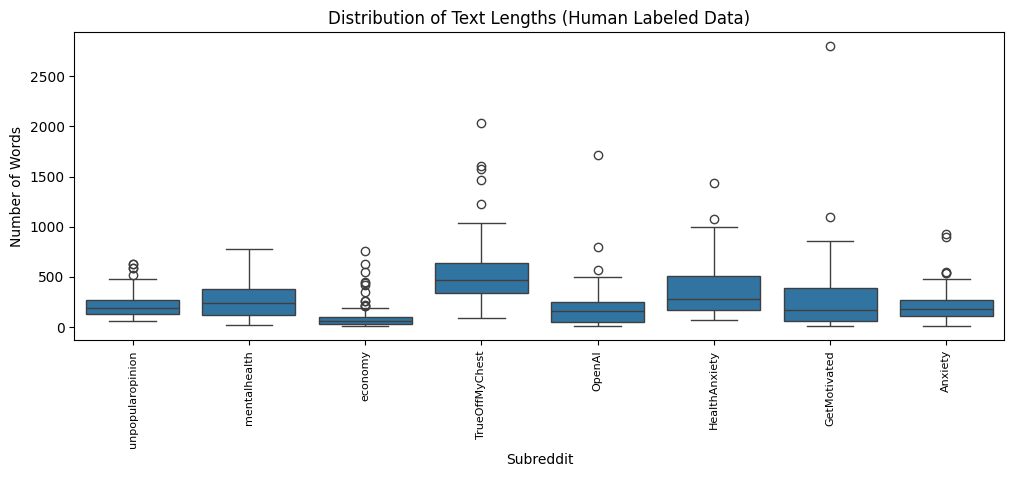

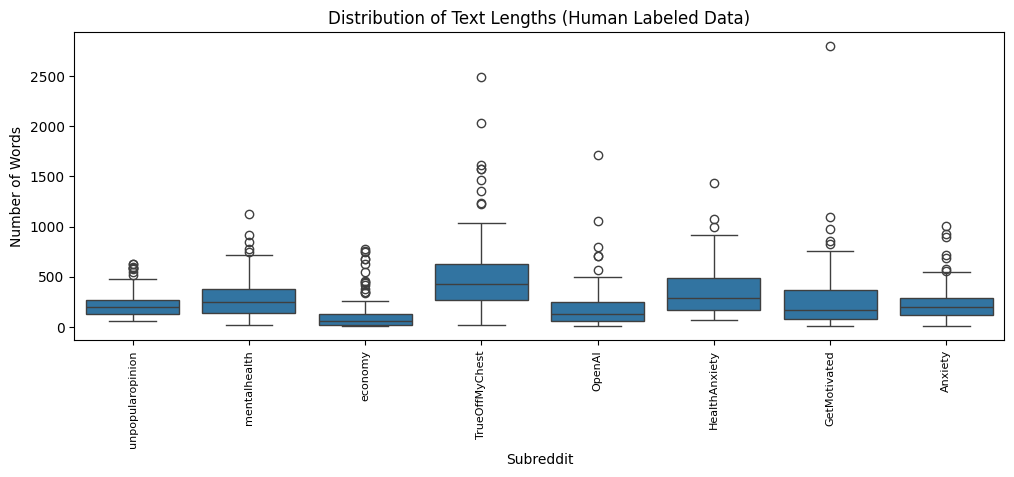

In [6]:
examine_text(human_label, 'text_all')
examine_text(ai_label, 'text_all')

Major text length looks similar, mainly below 500 words.

---

## **2. Dataset Comparison**

Prepare and train DistilBERT model on labeled Reddit posts.

In [7]:
# test text processing methods using simple distilBERT model
from datasets import Dataset, DatasetDict
def split_data(indf, target_col = 'anxiety_level', test_size=0.2, val_size=0.1, random_state=42):
    """
    Split the dataframe into training, testing and validation sets.
    """
    train_df, test_df = train_test_split(indf, test_size=test_size, random_state=random_state, stratify=indf[target_col])
    train_val_df, val_df = train_test_split(train_df, test_size=val_size, random_state=random_state, stratify=train_df[target_col])

    dataset = DatasetDict({
        "train": Dataset.from_pandas(train_val_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    })
    return dataset

In [8]:
from functools import partial
import accelerate
import os
import time
from copy import deepcopy
from functools import partial

os.environ.setdefault("TOKENIZERS_PARALLELISM", "true")
# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

# Tokenize the dataset
def tokenize(batch, text_col):
    return tokenizer(batch[text_col], truncation=True, padding=True)

human_dataset = split_data(human_label, "anxiety_level", test_size=0.2, val_size=0.1, random_state=42)
ai_dataset = split_data(ai_label, "anxiety_level", test_size=0.2, val_size=0.1, random_state=42)

configs = [
    (human_dataset, "human_label"),
    (ai_dataset, "ai_label")
]

num_proc = max(1, min(os.cpu_count() or 1, 8))
tokenized_cache = {}
model_cache = {}

start_time = time.time()
df_list, metrics_result = [], []
print("Starting experiments...")

for df, df_name in configs:
    print(f"Testing {df_name}...")

    cache_key = (df_name)
    if cache_key not in tokenized_cache:
        map_kwargs = dict(
            batched=True,
            load_from_cache_file=True,
            desc=f"Tokenizing {df_name}",
        )
        if num_proc > 1:
            map_kwargs["num_proc"] = num_proc

        tokenized_dataset = df.map(partial(tokenize, text_col="text_all"), **map_kwargs)
        tokenized_dataset = tokenized_dataset.rename_column("anxiety_level", "labels")
        tokenized_dataset = tokenized_dataset.with_format("torch")
        tokenized_cache[cache_key] = tokenized_dataset
    else:
        tokenized_dataset = tokenized_cache[cache_key]

    num_labels = len(set(tokenized_dataset["train"]["labels"]))
    if num_labels not in model_cache:
        model_cache[num_labels] = DistilBertForSequenceClassification.from_pretrained(
            checkpoint, num_labels=num_labels
        )
    model = deepcopy(model_cache[num_labels])

    # simple args for quick testing
    args = TrainingArguments(
    output_dir="distilbert-text-clf",
    save_strategy="no",
    learning_rate=7e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.0,
    logging_strategy="no",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate(tokenized_dataset["test"])

    df_list.append(df_name)
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for all experiments: {total_time:.2f} seconds")

metrics_df = pd.DataFrame(metrics_result)
metrics_df["dataset"] = df_list
metrics_df = metrics_df[
    ["dataset"]
    + [col for col in metrics_df.columns if col not in {"dataset"}]
]
display(metrics_df)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Starting experiments...
Testing human_label...


Tokenizing human_label (num_proc=8):   0%|          | 0/431 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing human_label (num_proc=8):   0%|          | 0/48 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing human_label (num_proc=8):   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Testing ai_label...


Tokenizing ai_label (num_proc=8):   0%|          | 0/720 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing ai_label (num_proc=8):   0%|          | 0/80 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing ai_label (num_proc=8):   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Total time for all experiments: 420.95 seconds


,dataset,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,human_label,2.705281,0.658333,0.522697,0.433403,0.658333,0.769991,0.613153,12.5965,9.526,0.318,1.0
1,ai_label,1.898472,0.800000,0.799520,0.809394,0.800000,0.880602,0.868940,26.8545,7.448,0.261,1.0


**Key Finding** 
- AI-labeled runs are ahead across the board: 
    - higher accuracy (0.80 vs 0.66), 
    - weighted F1 (0.80 vs 0.52), 
    - and especially the ranking metrics—ROC AUC at 0.881 vs 0.770 and 
    - Average Precision at 0.869 vs 0.613. 
    - That suggests the AI annotations for this setup are cleaner or simply better aligned with the model’s inductive bias.
- AI labeled data makes distilBERT model has better performance. based on the result of comparison, we will use ai_label dataset for imporved training.
- this might due to human labeled contains more human bias, incosistency. human labeled dataset is labeled by one person in this project due to limited time, hence heavy incosistency might be introduced, this might cause by personal opionion, preference, mental fatigues. 

In [9]:
# using cached tokenized dataset and model to do final training
tokenized_dataset = tokenized_cache[("ai_label")]
model = deepcopy(model_cache[len(set(tokenized_dataset["train"]["labels"]))])

epochs_list = [5, 3, 2]
learning_rate_list = [1e-4, 3e-5, 5e-5]
weight_decay_list = [0.01, 0.03, 0.05]

use_cuda_fp16 = torch.cuda.is_available()


epoch_result, learning_rate_result, weight_decay_result, metrics_result = [], [], [], []
start_time = time.time()
for i in range(len(epochs_list)):
    epochs = epochs_list[i]
    lr = learning_rate_list[i]
    wd = weight_decay_list[i]
    print(f"Training with epochs={epochs}, lr={lr}, weight_decay={wd}")
    args = TrainingArguments(
        output_dir="distilbert-text-clf",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=epochs,
        weight_decay=wd,
        logging_strategy="epoch",
        fp16=use_cuda_fp16
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate(tokenized_dataset["test"])
    epoch_result.append(epochs)
    learning_rate_result.append(lr)
    weight_decay_result.append(wd)
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for hyperparameter tuning: {total_time:.2f} seconds")

metrics_comparison = pd.DataFrame(metrics_result)
metrics_comparison["epochs"] = epoch_result
metrics_comparison["learning_rate"] = learning_rate_result
metrics_comparison["weight_decay"] = weight_decay_result
metrics_comparison = metrics_comparison[
    ["epochs", "learning_rate", "weight_decay"]
    + [col for col in metrics_comparison.columns if col not in {"epochs", "learning_rate", "weight_decay"}]
]
display(metrics_comparison)

Training with epochs=5, lr=0.0001, weight_decay=0.01


Step,Training Loss
45,2.237600
90,0.472000
135,0.290200
180,0.130700
225,0.047700


Training with epochs=3, lr=3e-05, weight_decay=0.03


Step,Training Loss
45,0.050100
90,0.034200
135,0.028100


Training with epochs=2, lr=5e-05, weight_decay=0.05


Step,Training Loss
45,0.065000
90,0.011800


Total time for hyperparameter tuning: 3641.02 seconds


,epochs,learning_rate,weight_decay,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,5,0.00010,0.01,0.676885,0.825,0.825109,0.826250,0.825,0.918797,0.924937,31.3425,6.381,0.223,5.0
1,3,0.00003,0.03,0.944411,0.830,0.829898,0.835800,0.830,0.927318,0.931835,20.4098,9.799,0.343,3.0
2,2,0.00005,0.05,1.271806,0.835,0.834839,0.841777,0.835,0.919749,0.923445,20.1903,9.906,0.347,2.0
